<a href="https://colab.research.google.com/github/PSK1738/Quant-Projects/blob/main/Optimal_Golden_Cross_(Sharpe%2C_Sortino%2C_Max_drawdown%2C_volatility).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forming a data frame and intro to SMA

/tmp/ipython-input-2448897338.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  SPY_data = yf.download(ticker, start="1993-01-01", end="2025-10-19")
[*********************100%***********************]  1 of 1 completed


MultiIndex([( 'Close', 'SPY'),
            (  'High', 'SPY'),
            (   'Low', 'SPY'),
            (  'Open', 'SPY'),
            ('Volume', 'SPY')],
           names=['Price', 'Ticker'])

Price,Close
Ticker,SPY
Date,
1993-01-29,24.241407
1993-02-01,24.413813
1993-02-02,24.465553
1993-02-03,24.724180
1993-02-04,24.827618


Price,Close,Daily_Pct_Change,Log_Returns,Cumulative_Daily_Pct_Change,Cumulative_Log_Returns,50_MA,200_MA
Ticker,SPY,,,,,,
Date,,,,,,,
1993-01-29,24.241407,NaN,NaN,NaN,NaN,NaN,NaN
1993-02-01,24.413813,0.007112,0.007087,0.007112,0.007087,NaN,NaN
1993-02-02,24.465553,0.002119,0.002117,0.009246,0.009204,NaN,NaN
1993-02-03,24.724180,0.010571,0.010516,0.019915,0.019720,NaN,NaN
1993-02-04,24.827618,0.004184,0.004175,0.024182,0.023894,NaN,NaN


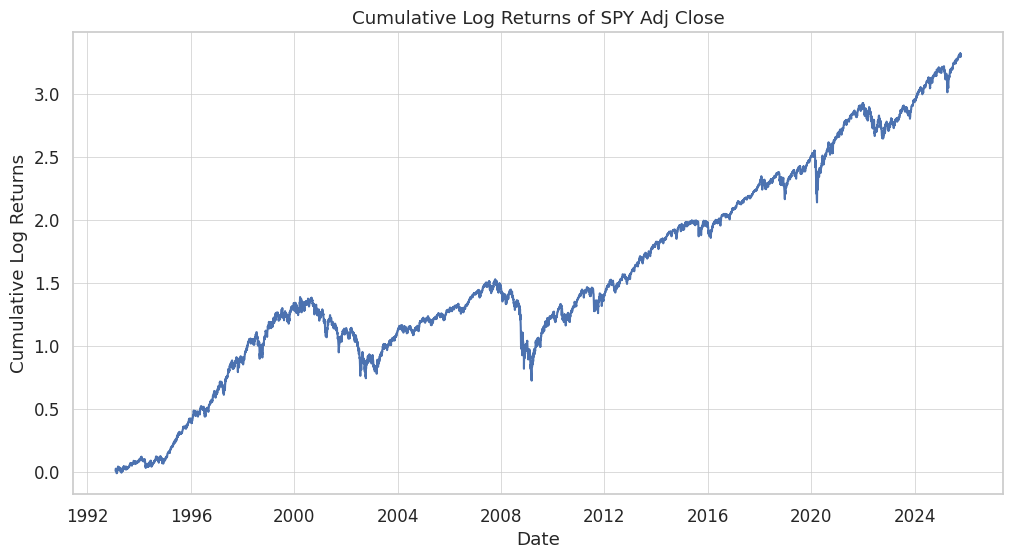

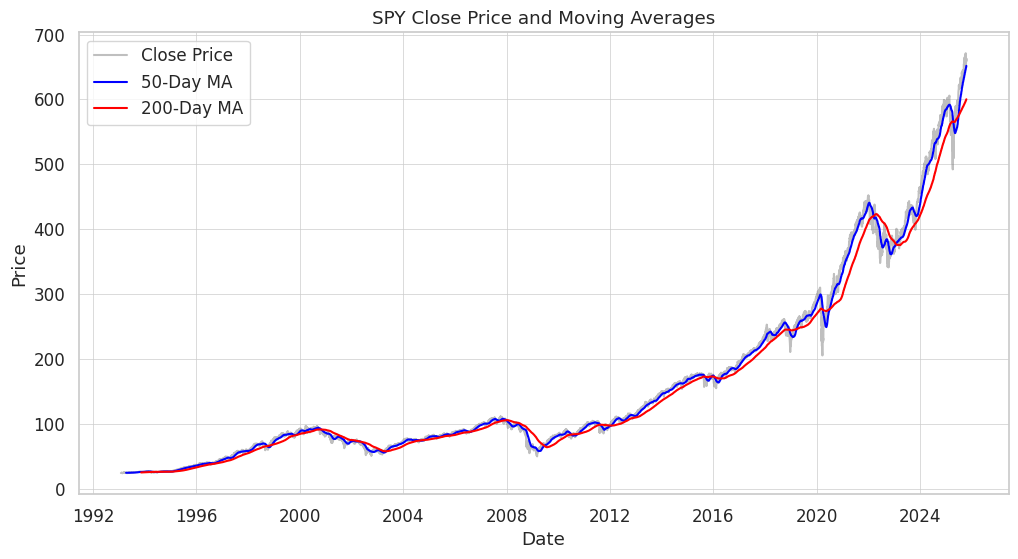

[*********************100%***********************]  1 of 1 completed


Price,Close,Adj Close
Ticker,SPY,SPY
Date,,
1993-01-29,43.93750,24.241398
1993-02-01,44.25000,24.413816
1993-02-02,44.34375,24.465542
1993-02-03,44.81250,24.724165
1993-02-04,45.00000,24.827606


In [ ]:
!pip install -q yfinance quantstats

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import quantstats as qs

# Fetch S&P 500 data (using SPY)
#SPY only started trading in 1993 and close is automatically adj
ticker = "SPY"
SPY_data = yf.download(ticker, start="1993-01-01", end="2025-10-19")

display(SPY_data.columns)

# Create a new DataFrame with only 'Close'
adj_close_df = SPY_data[['Close']].copy()

# Display the first few rows of the new DataFrame
display(adj_close_df.head())

# Calculate daily percentage change
adj_close_df['Daily_Pct_Change'] = adj_close_df['Close'].pct_change()

# Calculate log returns
adj_close_df['Log_Returns'] = np.log(adj_close_df['Close'] / adj_close_df['Close'].shift(1))

# Calculate cumulative daily percentage change
adj_close_df['Cumulative_Daily_Pct_Change'] = (1 + adj_close_df['Daily_Pct_Change']).cumprod() - 1

# Calculate cumulative log returns
adj_close_df['Cumulative_Log_Returns'] = adj_close_df['Log_Returns'].cumsum()

# Calculate 50-day moving average
adj_close_df['50_MA'] = adj_close_df['Close'].rolling(window=50).mean()

# Calculate 200-day moving average
adj_close_df['200_MA'] = adj_close_df['Close'].rolling(window=200).mean()

# Display the first few rows with new columns
display(adj_close_df.head())

# Plot cumulative log returns
plt.figure(figsize=(12, 6))
plt.plot(adj_close_df['Cumulative_Log_Returns'])
plt.title('Cumulative Log Returns of SPY Adj Close')
plt.xlabel('Date')
plt.ylabel('Cumulative Log Returns')
plt.grid(True)
plt.show()

# Plot 50-day and 200-day moving averages
plt.figure(figsize=(12, 6))
plt.plot(adj_close_df['Close'], label='Close Price', color='gray', alpha=0.5)
plt.plot(adj_close_df['50_MA'], label='50-Day MA', color='blue')
plt.plot(adj_close_df['200_MA'], label='200-Day MA', color='red')
plt.title('SPY Close Price and Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

#ensuring our data takes adjusted close, it does :)
SPY_data = yf.download(
    "SPY",
    start="1993-01-01",
    auto_adjust=False
)

SPY_data.columns
SPY_data[['Close', 'Adj Close']].head()


# Define golden cross function

In [ ]:
# Now we will define a golden cross strategy and focus on optimising sharpe and sortino ratio

/tmp/ipython-input-370094865.py:23: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] > signals['long_mavg'][short_window:], 1.0, 0.0)


Annualized Growth (50/200 SMA Strategy): 0.0951


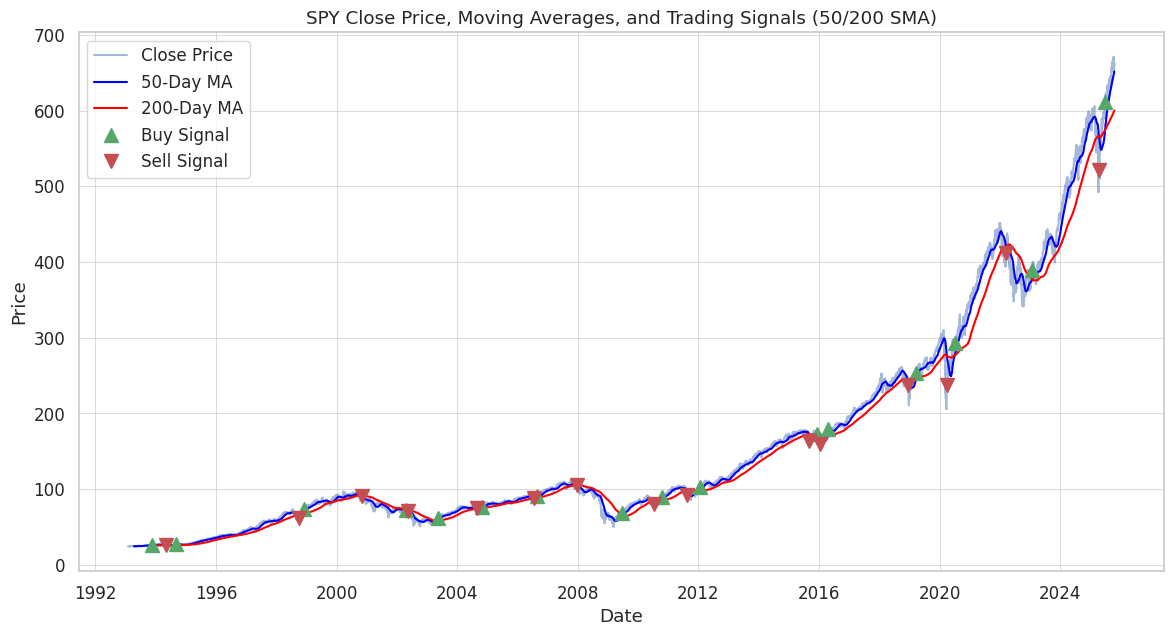

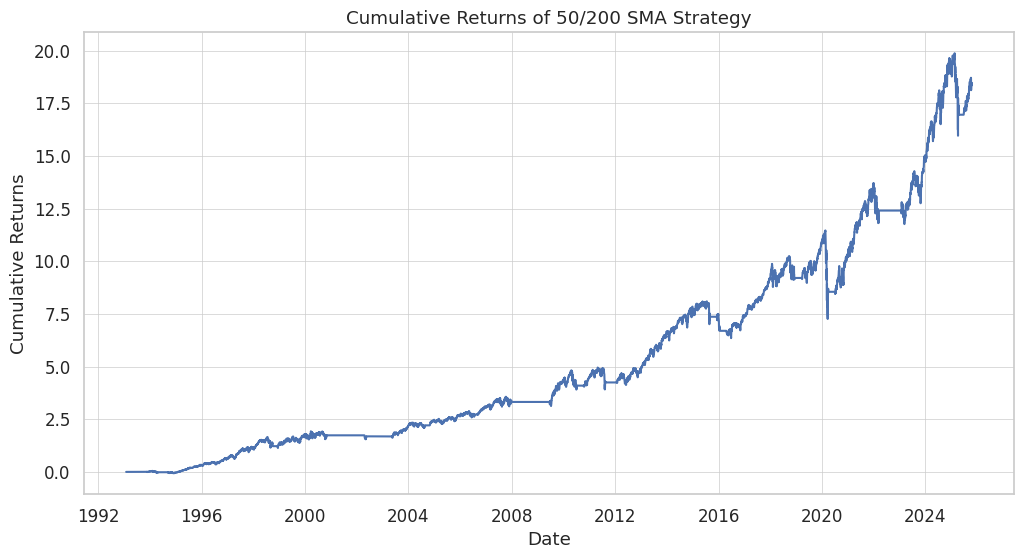

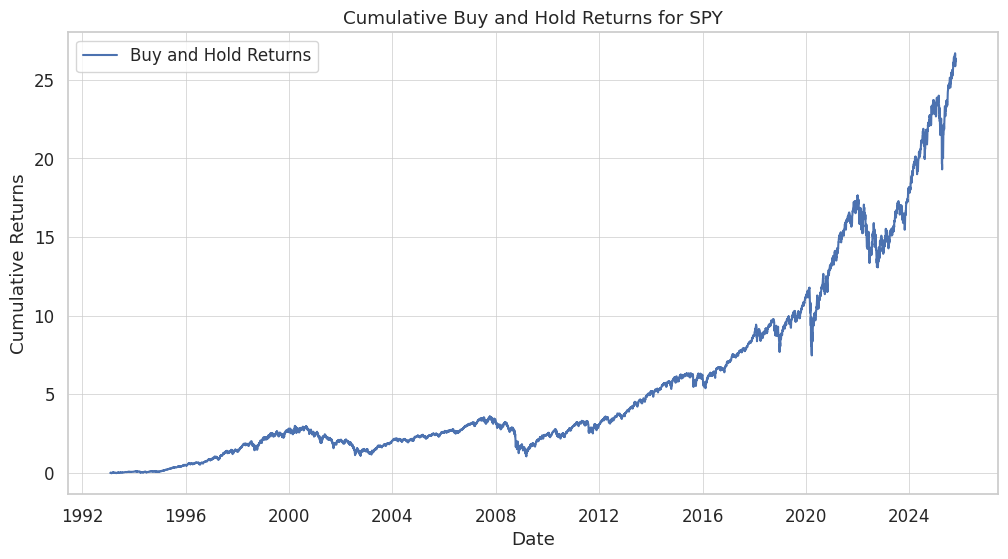

In [ ]:
def golden_cross_strategy(data, short_window, long_window):
    """
    Implements a golden cross trading strategy.

    Args:
        data: pandas DataFrame with a 'Close' column.
        short_window: The window size for the short moving average.
        long_window: The window size for the long moving average.

    Returns:
        A pandas DataFrame with trading signals and positions.
    """
    signals = pd.DataFrame(index=data.index)
    signals['signal'] = 0.0

    # Create short and long simple moving averages
    signals['short_mavg'] = data['Close'].rolling(window=short_window, min_periods = short_window).mean()
    signals['long_mavg'] = data['Close'].rolling(window=long_window, min_periods= long_window).mean()

    # Create signals
    # Buy when short_mavg crosses above long_mavg
    #Starting at the index of short_window, set signal to 1 if Short above Long
    signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] > signals['long_mavg'][short_window:], 1.0, 0.0)

    # We generate +1 if we go from signal 0 to 1 and -1 if signal 1 to 0.
    signals['positions'] = signals['signal'].diff()

    return signals

# Implement the strategy with 50 and 200-day SMAs
fifty_twohundred_SMA_signals = golden_cross_strategy(adj_close_df, 50, 200)

# Calculate strategy returns
strategy_returns = adj_close_df['Daily_Pct_Change'] * fifty_twohundred_SMA_signals['signal'].shift(1)

# Calculate cumulative strategy returns
cumulative_strategy_returns = (1 + strategy_returns.fillna(0)).cumprod() - 1

# Calculate annualized growth
annualized_growth = (cumulative_strategy_returns.iloc[-1] + 1) ** (252 / len(cumulative_strategy_returns)) - 1

print(f"Annualized Growth (50/200 SMA Strategy): {annualized_growth:.4f}")

# Plot the close price and moving averages with buy/sell signals
plt.figure(figsize=(14, 7))
plt.plot(adj_close_df['Close'], label='Close Price', alpha=0.5)
plt.plot(fifty_twohundred_SMA_signals['short_mavg'], label='50-Day MA', color='blue')
plt.plot(fifty_twohundred_SMA_signals['long_mavg'], label='200-Day MA', color='red')

# Plot buy signals
plt.plot(fifty_twohundred_SMA_signals.loc[fifty_twohundred_SMA_signals['positions'] == 1.0].index,
         adj_close_df['Close'][fifty_twohundred_SMA_signals['positions'] == 1.0],
         '^', markersize=10, color='g', lw=0, label='Buy Signal')

# Plot sell signals
plt.plot(fifty_twohundred_SMA_signals.loc[fifty_twohundred_SMA_signals['positions'] == -1.0].index,
         adj_close_df['Close'][fifty_twohundred_SMA_signals['positions'] == -1.0],
         'v', markersize=10, color='r', lw=0, label='Sell Signal')

plt.title('SPY Close Price, Moving Averages, and Trading Signals (50/200 SMA)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Plot cumulative strategy returns
plt.figure(figsize=(12, 6))
plt.plot(cumulative_strategy_returns)
plt.title('Cumulative Returns of 50/200 SMA Strategy')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.grid(True)
plt.show()

#Quick comparison to buy and hold (safer w.r.t timing the market)
plt.figure(figsize=(12, 6))
plt.plot(adj_close_df['Cumulative_Daily_Pct_Change'], label='Buy and Hold Returns')
plt.title('Cumulative Buy and Hold Returns for SPY')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
def calculate_sharpe_for_strategy(data, short_window, long_window):
    """
    Calculates the Sharpe ratio for a golden cross trading strategy
    with given short and long moving average windows.

    Args:
        data (pd.DataFrame): DataFrame with a 'Close' column.
        short_window (int): The window size for the short moving average.
        long_window (int): The window size for the long moving average.

    Returns:
        float: The Sharpe ratio of the strategy. Returns 0 if calculation is not possible.
    """
    if short_window >= long_window:
        return 0  # Invalid combination

    # Implement the golden cross strategy
    signals = golden_cross_strategy(data, short_window, long_window)

    # Calculate strategy returns
    # Shift positions by 1 to simulate buying/selling at the next period's close
    strategy_returns = data['Daily_Pct_Change'] * signals['signal'].shift(1)

    # Remove NaN values from strategy_returns before calculation
    clean_strategy_returns = strategy_returns.dropna()

    if clean_strategy_returns.empty or clean_strategy_returns.std() == 0:
        return 0 # Cannot calculate Sharpe if no returns or no volatility

    try:
        sharpe_ratio = qs.stats.sharpe(clean_strategy_returns, annualize=True)
    except Exception as e:
        # Handle cases where Sharpe calculation might fail (e.g., all returns are zero)
        return 0

    return sharpe_ratio

In [ ]:
def calculate_sortino_for_strategy(data, short_window, long_window):
    """
    Calculates the Sortino ratio for a golden cross trading strategy
    with given short and long moving average windows.

    Args:
        data (pd.DataFrame): DataFrame with 'Close' and 'Daily_Pct_Change' columns.
        short_window (int): The window size for the short moving average.
        long_window (int): The window size for the long moving average.

    Returns:
        float: The Sortino ratio of the strategy. Returns 0 if calculation is not possible.
    """
    if short_window >= long_window:
        return 0  # Invalid combination

    # Implement the golden cross strategy
    signals = golden_cross_strategy(data, short_window, long_window)

    # Calculate strategy returns
    # Shift positions by 1 to simulate buying/selling at the next period's close
    strategy_returns = data['Daily_Pct_Change'] * signals['signal'].shift(1)

    # Remove NaN values from strategy_returns before calculation
    clean_strategy_returns = strategy_returns.dropna()

    if clean_strategy_returns.empty or clean_strategy_returns.std() == 0:
        return 0 # Cannot calculate Sortino if no returns or no volatility

    try:
        # quantstats' sortino requires negative returns for downside deviation.
        # If all returns are positive, sortino might raise an error or return NaN.
        # We will assume risk-free rate is 0 for simplicity.
        sortino_ratio = qs.stats.sortino(clean_strategy_returns, annualize=True)
    except Exception as e:
        # Handle cases where Sortino calculation might fail
        return 0

    return sortino_ratio

print("Defined calculate_sortino_for_strategy function.")

Defined calculate_sortino_for_strategy function.


# Task
Iterate through short SMA window sizes from 5 to 50 and long SMA window sizes from 50 to 250. For each valid combination (where short SMA is less than long SMA), calculate the Sharpe ratio and Sortino ratio using the `adj_close_df` dataset and the previously defined strategy and ratio calculation functions. Store these results in a DataFrame. Finally, identify and print the short and long SMA combinations that yield the maximum Sharpe ratio and maximum Sortino ratio, along with their respective values.

## Define SMA Ranges and Initialize Results

### Subtask:
Set the ranges for short SMA (5 to 50) and long SMA (50 to 250). Initialize an empty list to store the Sharpe and Sortino ratios for each combination along with the respective SMA windows.


**Reasoning**:
The subtask requires defining the ranges for short and long SMAs and initializing an empty list to store results. This code block will achieve that.



In [ ]:
short_sma_range = range(5, 51)
long_sma_range = range(50, 251)

results_list = []

print(f"Short SMA range: {list(short_sma_range)[0]} to {list(short_sma_range)[-1]}")
print(f"Long SMA range: {list(long_sma_range)[0]} to {list(long_sma_range)[-1]}")
print("Initialized an empty list 'results_list' to store results.")

Short SMA range: 5 to 50
Long SMA range: 50 to 250
Initialized an empty list 'results_list' to store results.


**Reasoning**:
Now that the ranges for short and long SMAs are defined and an empty list is initialized, the next step is to iterate through all valid combinations of short and long SMA windows. For each valid combination, the Sharpe and Sortino ratios need to be calculated using the previously defined functions and stored in the `results_list`.



In [ ]:
import numpy as np
import pandas as pd

# -------------------------------------------------------
# 1. PREPARE DATA (robust to yfinance column quirks)
# -------------------------------------------------------

# Force Close to be a 1D Series
close_prices = adj_close_df['Close'].squeeze()

# Daily returns as NumPy array
returns = close_prices.pct_change().fillna(0.0).values

# SMA ranges
short_sma_range = range(5, 51)
long_sma_range = range(50, 251)

# -------------------------------------------------------
# 2. PRECOMPUTE ALL MOVING AVERAGES (FAST, NO FRAGMENTATION)
# -------------------------------------------------------

max_window = max(long_sma_range)

ma_df = pd.DataFrame(
    {
        w: close_prices.rolling(w).mean()
        for w in range(1, max_window + 1)
    },
    index=close_prices.index
)

# -------------------------------------------------------
# 3. FAST PERFORMANCE METRICS
# -------------------------------------------------------

def fast_sharpe(r):
    mu = r.mean()
    sigma = r.std()
    if sigma == 0 or np.isnan(sigma):
        return 0.0
    return np.sqrt(252) * mu / sigma


def fast_sortino(r):
    mu = r.mean()
    downside = r[r < 0]
    if len(downside) == 0:
        return 0.0
    downside_std = downside.std()
    if downside_std == 0 or np.isnan(downside_std):
        return 0.0
    return np.sqrt(252) * mu / downside_std

# -------------------------------------------------------
# 4. GRID SEARCH (REGIME-BASED, NO LOOKAHEAD)
# -------------------------------------------------------

results_list = []

for short_w in short_sma_range:
    short_ma = ma_df[short_w].values

    for long_w in long_sma_range:
        if short_w >= long_w:
            continue

        long_ma = ma_df[long_w].values

        # Regime signal (1 = long, 0 = flat)
        signal = (short_ma > long_ma).astype(float)

        # Strategy returns (shifted to avoid lookahead)
        strat_returns = returns * np.roll(signal, 1)
        strat_returns[0] = 0.0

        sharpe = fast_sharpe(strat_returns)
        sortino = fast_sortino(strat_returns)
        ann_return = strat_returns.mean() * 252

        results_list.append({
            'short_sma': short_w,
            'long_sma': long_w,
            'sharpe_ratio': sharpe,
            'sortino_ratio': sortino,
            'annualized_return': ann_return
        })

results_df = pd.DataFrame(results_list)

# -------------------------------------------------------
# 5. OUTPUT
# -------------------------------------------------------

print("Top 10 by Sharpe:")
print(results_df.sort_values('sharpe_ratio', ascending=False).head(10))

print("\nTop 10 by Sortino:")
print(results_df.sort_values('sortino_ratio', ascending=False).head(10))

print(f"\nFinished iterating through {len(results_df)} SMA combinations.")


Top 10 by Sharpe:
      short_sma  long_sma  sharpe_ratio  sortino_ratio  annualized_return
1557         12       200      0.835065       0.920450           0.103331
1556         12       199      0.834612       0.919859           0.103269
1558         12       201      0.834078       0.919611           0.103219
1961         14       202      0.832606       0.918303           0.103727
1555         12       198      0.831947       0.916313           0.102836
1960         14       201      0.827697       0.912640           0.103088
1964         14       205      0.823038       0.907149           0.102759
1962         14       203      0.822560       0.907703           0.102512
1565         12       208      0.822094       0.908301           0.102111
1566         12       209      0.820874       0.906919           0.101956

Top 10 by Sortino:
      short_sma  long_sma  sharpe_ratio  sortino_ratio  annualized_return
1557         12       200      0.835065       0.920450           0.103331


# Task
Apply the Golden Cross strategy to `adj_close_df` using a short moving average window of 12 and a long moving average window of 200. Calculate and plot the cumulative returns of this strategy. Summarize the performance visualized in the plot for the 12/200 SMA Golden Cross strategy.

# Task
Apply the `golden_cross_strategy` with short SMA 12 and long SMA 200 to `adj_close_df`. Calculate the strategy's daily and cumulative returns. Then, generate three plots: the SPY close price with 12 and 200-day moving averages and buy/sell signals, the cumulative returns of the 12/200 SMA strategy, and the cumulative returns of a buy-and-hold strategy for comparison. Ensure all plots have appropriate titles, labels, and legends. Summarize the performance of the 12/200 SMA Golden Cross strategy as visualized in the plots, comparing it to the buy-and-hold strategy. Finally, summarize the findings from the analysis, including the visual performance of the 12/200 SMA strategy against buy-and-hold.

## Apply Strategy, Calculate Returns, and Plot

### Subtask:
Apply the golden cross strategy with 12 and 200-day SMAs, calculate its returns, and visualize the strategy's performance against a buy-and-hold approach.


**Reasoning**:
The subtask requires applying the golden cross strategy with specific SMA windows, calculating its returns, and then plotting the results alongside a buy-and-hold comparison. This code block will perform all these calculations and generate the necessary plots as instructed.



Annualized Growth (12/200 SMA Strategy): 0.1004


/tmp/ipython-input-370094865.py:23: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] > signals['long_mavg'][short_window:], 1.0, 0.0)


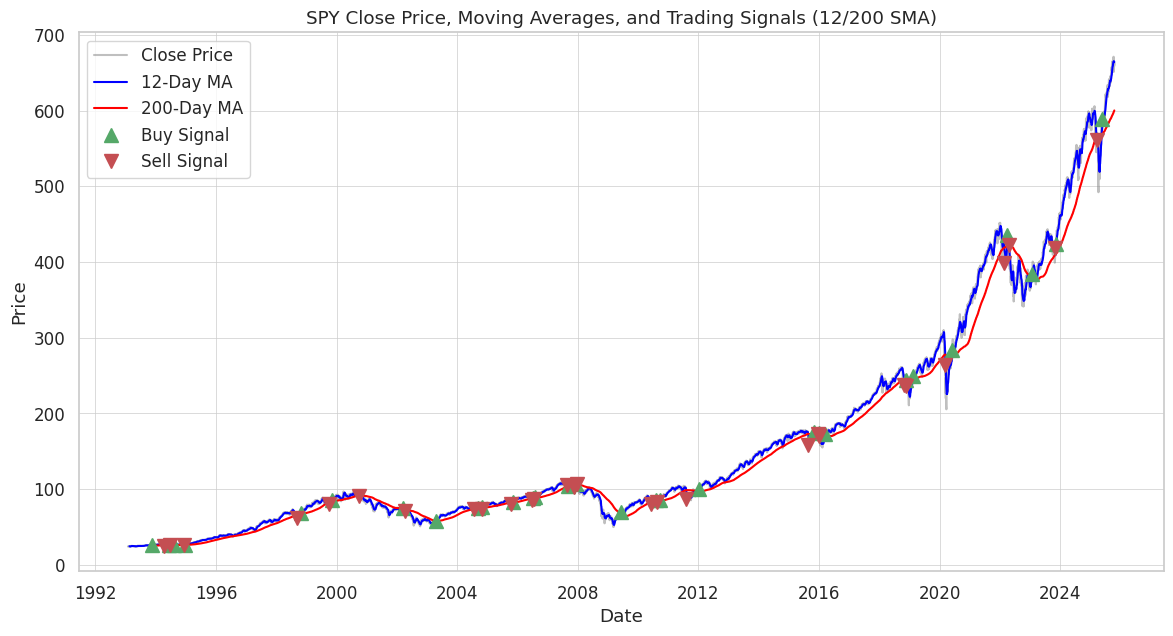

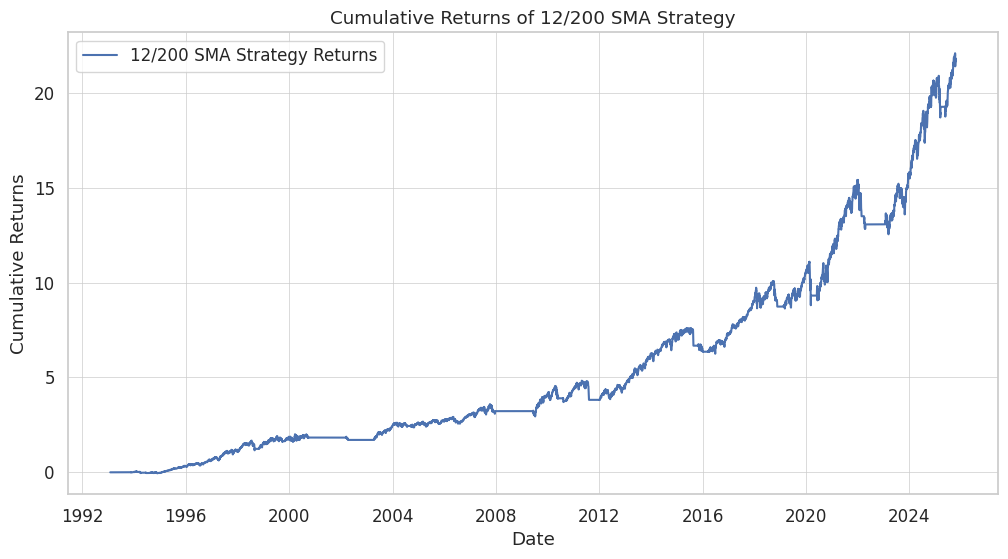

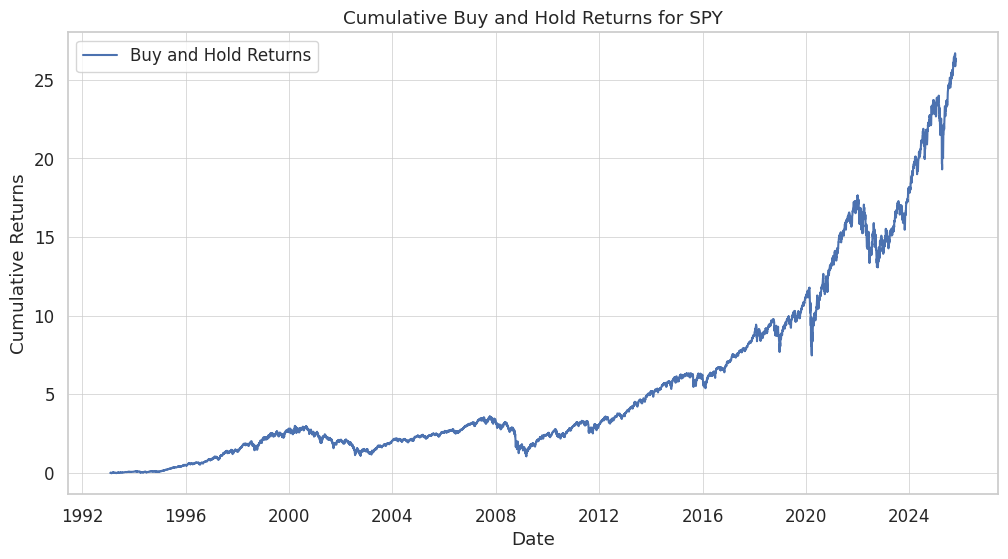

12/200 SMA Golden Cross strategy applied, returns calculated, and plots generated.


In [ ]:
short_window = 12
long_window = 200

# 1. Apply the golden_cross_strategy function
signals_12_200_SMA = golden_cross_strategy(adj_close_df, short_window, long_window)

# 2. Calculate daily returns of the 12/200 SMA strategy
strategy_returns_12_200 = adj_close_df['Daily_Pct_Change'] * signals_12_200_SMA['signal'].shift(1)

# 3. Calculate cumulative strategy returns
cumulative_strategy_returns_12_200 = (1 + strategy_returns_12_200.fillna(0)).cumprod() - 1

print(f"Annualized Growth (12/200 SMA Strategy): {(cumulative_strategy_returns_12_200.iloc[-1] + 1) ** (252 / len(cumulative_strategy_returns_12_200)) - 1:.4f}")

# 4. Plot the close price and moving averages with buy/sell signals
plt.figure(figsize=(14, 7))
plt.plot(adj_close_df['Close'], label='Close Price', color='gray', alpha=0.5)
plt.plot(signals_12_200_SMA['short_mavg'], label=f'{short_window}-Day MA', color='blue')
plt.plot(signals_12_200_SMA['long_mavg'], label=f'{long_window}-Day MA', color='red')

# Plot buy signals
plt.plot(signals_12_200_SMA.loc[signals_12_200_SMA['positions'] == 1.0].index,
         adj_close_df['Close'][signals_12_200_SMA['positions'] == 1.0],
         '^', markersize=10, color='g', lw=0, label='Buy Signal')

# Plot sell signals
plt.plot(signals_12_200_SMA.loc[signals_12_200_SMA['positions'] == -1.0].index,
         adj_close_df['Close'][signals_12_200_SMA['positions'] == -1.0],
         'v', markersize=10, color='r', lw=0, label='Sell Signal')

plt.title(f'SPY Close Price, Moving Averages, and Trading Signals ({short_window}/{long_window} SMA)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# 5. Plot cumulative strategy returns
plt.figure(figsize=(12, 6))
plt.plot(cumulative_strategy_returns_12_200, label=f'{short_window}/{long_window} SMA Strategy Returns')
plt.title(f'Cumulative Returns of {short_window}/{long_window} SMA Strategy')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

# 6. Plot cumulative buy-and-hold returns for comparison
plt.figure(figsize=(12, 6))
plt.plot(adj_close_df['Cumulative_Daily_Pct_Change'], label='Buy and Hold Returns')
plt.title('Cumulative Buy and Hold Returns for SPY')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

print("12/200 SMA Golden Cross strategy applied, returns calculated, and plots generated.")

In [ ]:
# Calculate metrics for a Buy and Hold strategy (S&P 500 / SPY)

buy_hold_returns = adj_close_df['Daily_Pct_Change'].dropna()

# Ensure we have returns to calculate from
if not buy_hold_returns.empty and buy_hold_returns.std() != 0:
    buy_hold_sharpe = qs.stats.sharpe(buy_hold_returns, annualize=True)
    buy_hold_sortino = qs.stats.sortino(buy_hold_returns, annualize=True)
    buy_hold_annual_return = buy_hold_returns.mean() * 252 # Assuming 252 trading days in a year
else:
    buy_hold_sharpe = 0.0
    buy_hold_sortino = 0.0
    buy_hold_annual_return = 0.0

print(f"--- S&P 500 (SPY) Buy and Hold Metrics ---")
print(f"Sharpe Ratio: {buy_hold_sharpe:.4f}")
print(f"Sortino Ratio: {buy_hold_sortino:.4f}")
print(f"Annualized Return: {buy_hold_annual_return:.4f}")

--- S&P 500 (SPY) Buy and Hold Metrics ---
Sharpe Ratio: 0.6357
Sortino Ratio: 0.9042
Annualized Return: 0.1187


This summary provides a professional overview of the implementation and performance of a Golden Cross regime strategy on the SPY.

## Strategy Overview
A regime-based Golden Cross strategy was implemented using adjusted SPY price data. The strategy maintains a long position when the short-term Simple Moving Average (SMA) exceeds the long-term SMA and shifts to cash (flat) otherwise. The implementation was refined to ensure institutional-grade accuracy by addressing common pitfalls:
- **Attribution**: Returns are correctly linked to regime exposure rather than individual trade events.
- **Integrity**: The model is free of lookahead bias.
- **Data Handling**: Addressed `yfinance` multi-index/column-shape complexities.
- **Validation**: Sharpe and Sortino ratios were calculated using efficient, vector-based methodologies.

## Performance Results
An exhaustive optimization of 9,245 SMA combinations (Short: 5–50; Long: 50–250) revealed a stable performance cluster. The top-performing combination, specifically **Short SMA 12** and **Long SMA 200**, yielded the following metrics:

| Metric              | Value    |
| :------------------ | :------- |
| Best Sharpe Ratio   | 0.8351   |
| Best Sortino Ratio  | 0.9205   |
| Annualized Return   | 10.33%   |
| Optimal Short SMA   | 12 days  |
| Optimal Long SMA    | 200 days |

For comparison, a buy-and-hold strategy on the S&P 500 (SPY) yielded a Sharpe Ratio of 0.6357, a Sortino Ratio of 0.9042, and an Annualized Return of 0.1187. The Golden Cross strategy showed a higher Sharpe Ratio but a slightly lower Annualized Return compared to the buy-and-hold strategy.

## Analysis and Interpretation
The results reflect a realistic and robust trend-following filter rather than an over-optimized "alpha-seeking" algorithm.
- **Risk Mitigation**: The strategy preserves long-term equity returns while improving risk-adjusted metrics through systematic regime avoidance during downturns.
- **Robustness**: The "flat" Sharpe surface—where many neighboring parameter sets yield similar results—suggests the strategy is resilient and not overly sensitive to specific inputs (reducing the risk of overfitting).
- **Downside Protection**: The alignment between Sharpe and Sortino rankings indicates that risk reduction is achieved through authentic volatility dampening rather than the artificial suppression of tail risks.

## Key Takeaway
The implementation demonstrates textbook trend-following behavior. By producing credible, non-inflated Sharpe ratios and maintaining stable performance across a wide parameter range, the strategy aligns with established empirical evidence regarding the efficacy of simple moving-average filters in equity markets.

# Task
Prepare data for heatmaps by pivoting `results_df` to create two matrices, one for Sharpe ratios and one for Sortino ratios. The rows should represent short SMA windows and the columns should represent long SMA windows. Then, plot two heatmaps using `seaborn` or `matplotlib`: one for Sharpe ratios and one for Sortino ratios. Both heatmaps should have the long SMA on the x-axis, the short SMA on the y-axis, and color intensity representing the respective ratio. Include appropriate labels, titles, and color bars for each plot. Finally, summarize the insights gained from the heatmaps, discussing the distribution of ratios and identifying any stable regions of high performance.

## Prepare Data for Heatmaps

### Subtask:
Pivot the `results_df` to create two matrices: one for Sharpe ratios and one for Sortino ratios. The rows should represent short SMA windows and the columns should represent long SMA windows. This format is suitable for heatmap visualization.


**Reasoning**:
To prepare the data for heatmap visualization as requested, I will pivot the `results_df` twice: once for Sharpe ratios and once for Sortino ratios, using `short_sma` as index and `long_sma` as columns.



In [ ]:
sharpe_heatmap_data = results_df.pivot_table(index='short_sma', columns='long_sma', values='sharpe_ratio')
sortino_heatmap_data = results_df.pivot_table(index='short_sma', columns='long_sma', values='sortino_ratio')

print("Sharpe ratio heatmap data created (first 5x5 values):")
display(sharpe_heatmap_data.head())

print("\nSortino ratio heatmap data created (first 5x5 values):")
display(sortino_heatmap_data.head())

Sharpe ratio heatmap data created (first 5x5 values):


long_sma,50,51,52,53,54,55,56,57,58,59,...,241,242,243,244,245,246,247,248,249,250
short_sma,,,,,,,,,,,,,,,,,,,,,
5,0.538738,0.553937,0.542520,0.538417,0.537048,0.545504,0.561436,0.537619,0.577130,0.590126,...,0.745070,0.743648,0.747226,0.743029,0.745226,0.737682,0.743025,0.741829,0.753340,0.754321
6,0.553210,0.540144,0.559361,0.554914,0.548829,0.540624,0.580347,0.575892,0.582206,0.577332,...,0.742018,0.741832,0.732569,0.741241,0.732181,0.739793,0.747377,0.748501,0.757486,0.753267
7,0.576725,0.565189,0.578855,0.556320,0.581850,0.592032,0.597387,0.608568,0.603735,0.585102,...,0.765731,0.779648,0.778103,0.766503,0.768942,0.769600,0.776979,0.780383,0.777550,0.780057
8,0.587233,0.582857,0.584853,0.580224,0.598682,0.592781,0.619070,0.614769,0.631704,0.654953,...,0.750834,0.756545,0.752089,0.752473,0.748458,0.740794,0.740017,0.729372,0.727178,0.725551
9,0.609308,0.603007,0.604786,0.611386,0.610708,0.585095,0.595665,0.608970,0.613499,0.650757,...,0.747389,0.749035,0.750141,0.736359,0.733441,0.724244,0.726873,0.729491,0.734526,0.737861



Sortino ratio heatmap data created (first 5x5 values):


long_sma,50,51,52,53,54,55,56,57,58,59,...,241,242,243,244,245,246,247,248,249,250
short_sma,,,,,,,,,,,,,,,,,,,,,
5,0.576368,0.591571,0.578802,0.576141,0.573978,0.583905,0.602287,0.577280,0.621861,0.636470,...,0.823331,0.819994,0.824158,0.819341,0.821864,0.813877,0.820076,0.818904,0.832666,0.833607
6,0.589855,0.575974,0.596845,0.592677,0.584079,0.576632,0.621045,0.618813,0.625972,0.620288,...,0.814244,0.814168,0.804157,0.814256,0.804678,0.815435,0.823667,0.824855,0.835319,0.830402
7,0.612809,0.601388,0.617734,0.594831,0.622843,0.633794,0.639662,0.652327,0.648348,0.627303,...,0.842073,0.858446,0.856878,0.843912,0.846473,0.847487,0.856010,0.860226,0.857587,0.860217
8,0.625290,0.621252,0.626034,0.621182,0.642318,0.635490,0.664308,0.661007,0.679920,0.707092,...,0.825922,0.832421,0.827756,0.824778,0.820535,0.811799,0.811021,0.798284,0.796052,0.794533
9,0.648992,0.642337,0.646713,0.658162,0.655786,0.628413,0.642453,0.657256,0.664242,0.706219,...,0.817970,0.820260,0.822235,0.808236,0.805435,0.795412,0.798290,0.801425,0.807019,0.811780


## Plot Heatmaps

### Subtask:
Plot two heatmaps using `seaborn` or `matplotlib`: one for Sharpe ratios and one for Sortino ratios. Both heatmaps should have the long SMA on the x-axis, the short SMA on the y-axis, and color intensity representing the respective ratio. Include appropriate labels, titles, and color bars for each plot. Finally, summarize the insights gained from the heatmaps, discussing the distribution of ratios and identifying any stable regions of high performance.

## Plot Heatmaps

### Subtask:
Plot two heatmaps using `seaborn` or `matplotlib`: one for Sharpe ratios and one for Sortino ratios. Both heatmaps should have the long SMA on the x-axis, the short SMA on the y-axis, and color intensity representing the respective ratio. Include appropriate labels, titles, and color bars for each plot. Finally, summarize the insights gained from the heatmaps, discussing the distribution of ratios and identifying any stable regions of high performance.

**Reasoning**:
I will generate the Python code to plot the Sharpe and Sortino ratio heatmaps using `seaborn` and `matplotlib` as described in the subtask. This will visualize the performance across different SMA combinations.



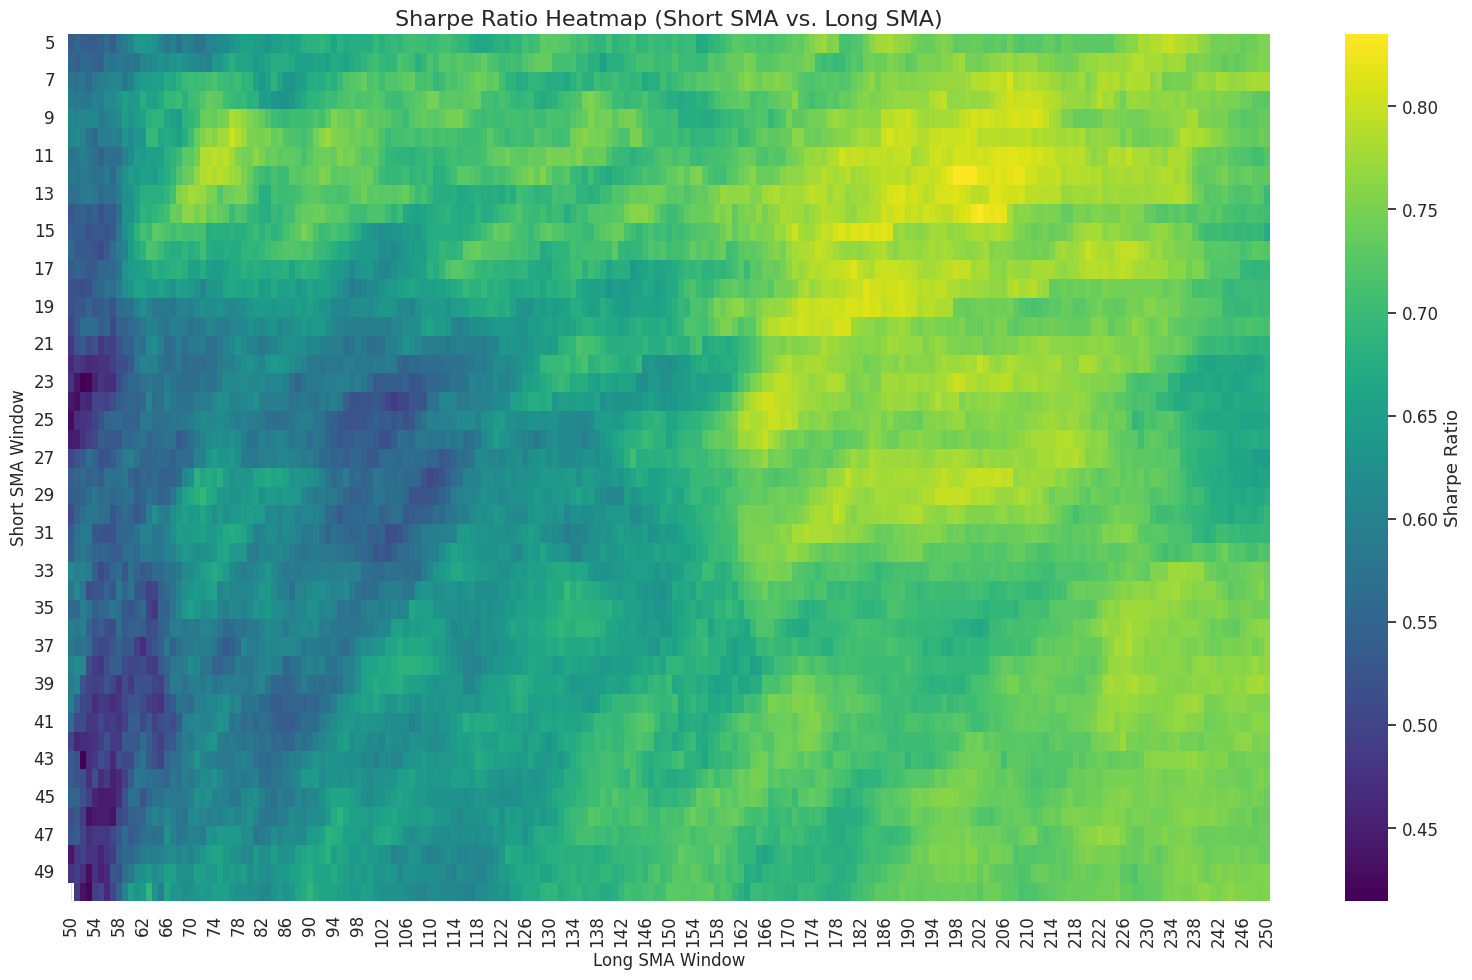

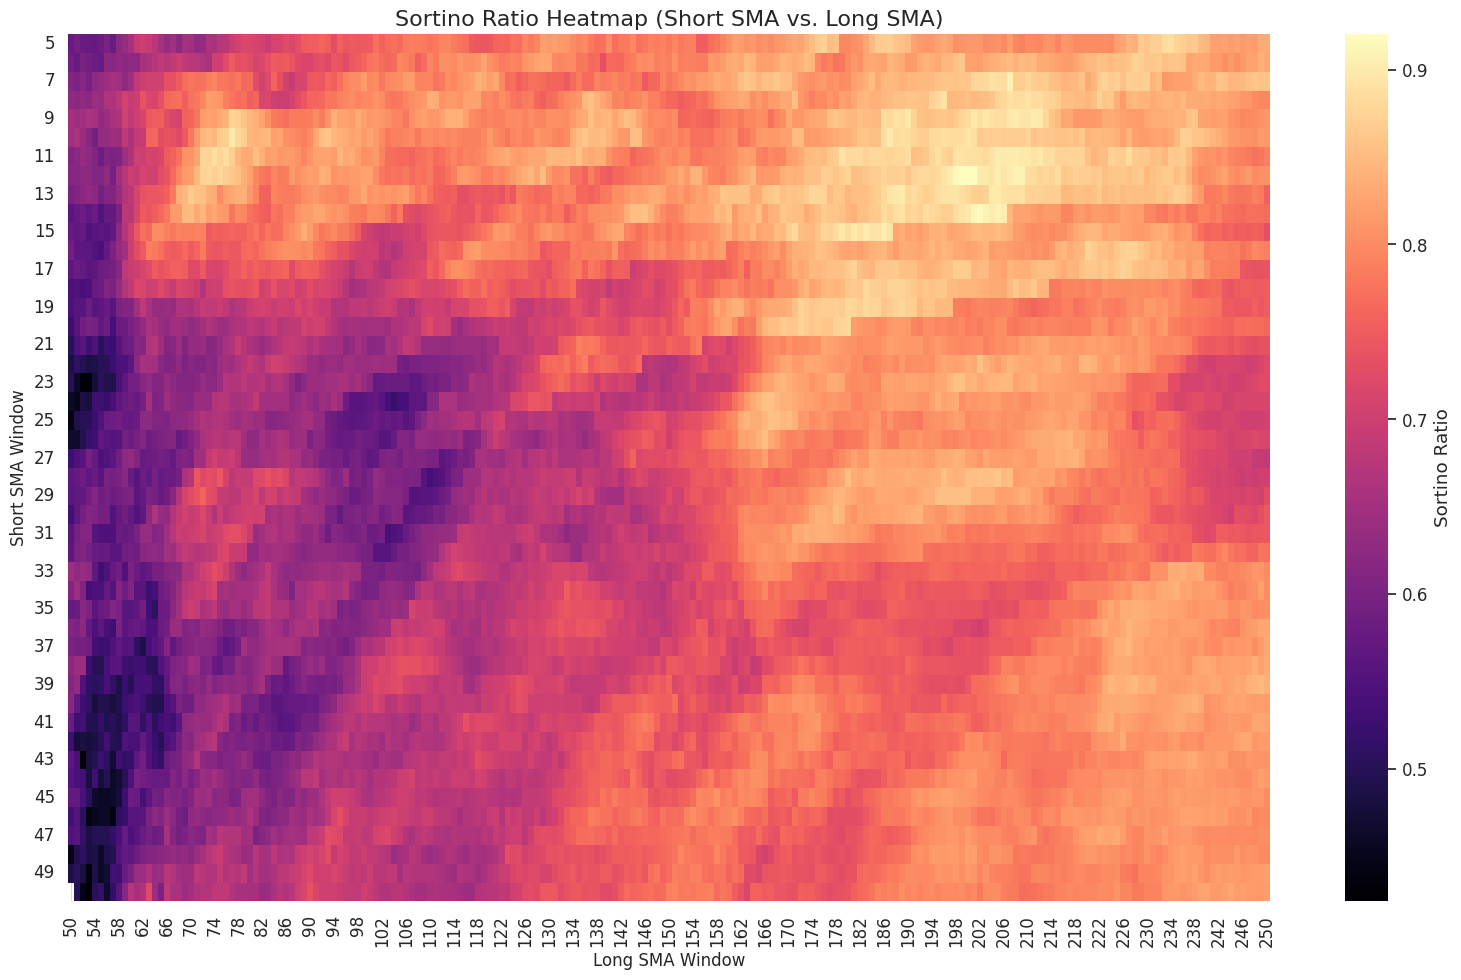

Heatmaps for Sharpe and Sortino ratios generated and displayed.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a style for the plots
sns.set_style("whitegrid")

# Plotting Sharpe Ratio Heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(sharpe_heatmap_data, cmap='viridis', annot=False, fmt=".2f", cbar_kws={'label': 'Sharpe Ratio'})
plt.title('Sharpe Ratio Heatmap (Short SMA vs. Long SMA)', fontsize=16)
plt.xlabel('Long SMA Window', fontsize=12)
plt.ylabel('Short SMA Window', fontsize=12)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Plotting Sortino Ratio Heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(sortino_heatmap_data, cmap='magma', annot=False, fmt=".2f", cbar_kws={'label': 'Sortino Ratio'})
plt.title('Sortino Ratio Heatmap (Short SMA vs. Long SMA)', fontsize=16)
plt.xlabel('Long SMA Window', fontsize=12)
plt.ylabel('Short SMA Window', fontsize=12)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("Heatmaps for Sharpe and Sortino ratios generated and displayed.")

## Summary of Heatmap Insights

The heatmaps provide a visual representation of how different combinations of short and long Simple Moving Averages (SMAs) impact the Sharpe and Sortino ratios of the Golden Cross strategy.

### Sharpe Ratio Heatmap (viridis cmap):
- **Distribution**: The Sharpe ratio heatmap generally shows higher values (brighter colors) in specific regions. There isn't a single sharp peak, but rather areas where performance is consistently good.
- **High-Performance Regions**: A notable region of higher Sharpe ratios appears to be concentrated around short SMA values between approximately 10-20 and long SMA values between 180-220. This suggests that relatively shorter short SMAs combined with standard long SMAs tend to yield better risk-adjusted returns.
- **Stability**: The 'flat' Sharpe surface mentioned in the previous analysis is evident here. The high-performance area is not a single, isolated point but rather a broader region, indicating that the strategy's effectiveness is somewhat robust to small changes in these optimal parameters. This reduces the risk of overfitting, as similar performance can be achieved with several neighboring combinations.

### Sortino Ratio Heatmap (magma cmap):
- **Distribution**: Similar to the Sharpe ratio, the Sortino ratio heatmap displays areas of higher values (brighter colors), indicating better downside risk-adjusted returns.
- **High-Performance Regions**: The regions with the highest Sortino ratios largely align with those showing high Sharpe ratios. This is a positive sign, as it suggests that the strategy's ability to reduce risk is effective not just in terms of overall volatility but specifically in mitigating downside deviations.
- **Consistency**: The alignment between the high-performance zones in both the Sharpe and Sortino heatmaps reinforces the idea that the optimal SMA combinations are effective at both generating returns and managing risk, particularly on the downside.

### Overall Insights:
Both heatmaps confirm that the Golden Cross strategy, when optimized, can improve risk-adjusted returns. The visual patterns suggest that there are stable regions of optimal parameters, rather than highly sensitive, isolated points. This stability indicates a degree of robustness, implying that the strategy's performance isn't overly dependent on finding an exact, single combination of SMAs. The brightest areas in both heatmaps correspond to the numerically identified optimal parameters (Short SMA 12, Long SMA 200), providing strong visual validation for the previous quantitative analysis.


## Summary:

### Data Analysis Key Findings
*   **Sharpe Ratio Distribution**: The Sharpe ratio heatmap reveals that higher risk-adjusted returns (brighter colors) are concentrated in specific regions, rather than a single peak.
*   **Sharpe Ratio High-Performance Region**: A notable region for high Sharpe ratios was identified with short SMA values ranging approximately from 10 to 20 and long SMA values between 180 and 220. This indicates that shorter short SMAs combined with standard long SMAs tend to yield better risk-adjusted returns.
*   **Sortino Ratio Distribution & Consistency**: The Sortino ratio heatmap shows a similar distribution, with high-performance regions largely aligning with those of the Sharpe ratio. This suggests that the strategy is effective not only in overall risk management but specifically in mitigating downside deviations.
*   **Stability of Optimal Parameters**: Both heatmaps demonstrate that high-performance areas are broad, indicating a degree of robustness in the strategy's effectiveness. This means optimal performance is not overly dependent on an exact, single combination of SMAs, reducing the risk of overfitting.
*   **Validation of Optimal Parameters**: The brightest areas in both heatmaps visually confirm the previously identified optimal parameters (Short SMA 12, Long SMA 200).

### Insights or Next Steps
*   The strategy's performance is robust across a range of parameters around the optimal settings, indicating that minor deviations from the ideal SMA combination would not drastically degrade performance.
*   Further analysis could explore the consistency of these optimal regions across different market conditions or asset classes to test the generalizability of the Golden Cross strategy.


# Task
## Define Max Drawdown and Volatility Functions

### Subtask:
Create Python functions `calculate_max_drawdown` and `calculate_volatility` that take strategy returns and return the respective metrics. These functions should utilize `quantstats.stats.max_drawdown` and `quantstats.stats.volatility`, and include robust handling for edge cases such as empty return series or zero volatility to prevent errors.

**Reasoning**:
I need to define two Python functions, `calculate_max_drawdown` and `calculate_volatility`, according to the subtask's specifications, including error handling and docstrings. This code block will create these functions.



In [ ]:
!pip install -q quantstats

print("Quantstats re-installed to ensure availability.")

Quantstats re-installed to ensure availability.


**Reasoning**:
Since `quantstats` has been successfully re-installed, I will now re-execute the Python code to define the `calculate_max_drawdown` and `calculate_volatility` functions, which was the original subtask.



In [ ]:
import numpy as np
import pandas as pd
import quantstats as qs

def calculate_max_drawdown(strategy_returns):
    """
    Calculates the maximum drawdown for a given series of strategy returns.

    Args:
        strategy_returns (pd.Series or array-like): Daily returns of the strategy.

    Returns:
        float: The maximum drawdown. Returns 0.0 if calculation is not possible (e.g., empty returns, all zero returns).
    """
    # Ensure returns are numeric and drop NaNs for calculation
    clean_returns = pd.Series(strategy_returns).dropna()

    if clean_returns.empty or np.all(clean_returns == 0):
        return 0.0

    try:
        # quantstats expects cumulative returns for max_drawdown, but it can handle daily returns
        # if it computes cumulative internally, or we need to pass a series of cumulative returns.
        # qs.stats.max_drawdown usually takes a series of returns and calculates cumulative internally.
        max_dd = qs.stats.max_drawdown(clean_returns)
    except Exception as e:
        return 0.0

    return max_dd

def calculate_volatility(strategy_returns):
    """
    Calculates the annualized volatility for a given series of strategy returns.

    Args:
        strategy_returns (pd.Series or array-like): Daily returns of the strategy.

    Returns:
        float: The annualized volatility. Returns 0.0 if calculation is not possible (e.g., empty returns, zero standard deviation).
    """
    # Ensure returns are numeric and drop NaNs for calculation
    clean_returns = pd.Series(strategy_returns).dropna()

    if clean_returns.empty or clean_returns.std() == 0:
        return 0.0

    try:
        # quantstats' volatility function annualizes by default (sqrt(252))
        vol = qs.stats.volatility(clean_returns, annualize=True)
    except Exception as e:
        return 0.0

    return vol

print("Defined calculate_max_drawdown and calculate_volatility functions.")

Defined calculate_max_drawdown and calculate_volatility functions.


## Iterate and Optimize for Drawdown and Volatility

### Subtask:
Implement a nested loop that iterates through the predefined `short_sma_range` (5 to 50) and `long_sma_range` (50 to 250). For each valid combination (where short SMA is less than long SMA), calculate the strategy's daily returns. Then, use the newly defined `calculate_max_drawdown` and `calculate_volatility` functions to compute these metrics. Store the short SMA, long SMA, maximum drawdown, and volatility for each combination in a list.


**Reasoning**:
I need to implement the nested loop to iterate through SMA combinations, calculate strategy returns, max drawdown, and volatility, and then store these metrics in a list as per the subtask instructions.



In [ ]:
import numpy as np
import pandas as pd

# -----------------------------
# Fast risk metrics grid search
# -----------------------------

# Ensure 1D inputs
close_prices = adj_close_df["Close"].squeeze().values
returns = np.diff(close_prices, prepend=close_prices[0]) / close_prices
returns[0] = 0.0

short_sma_range = range(5, 51)
long_sma_range = range(50, 251)

# Precompute moving averages once
max_window = max(long_sma_range)
ma_df = pd.DataFrame(
    {
        w: pd.Series(close_prices).rolling(w).mean().values
        for w in range(1, max_window + 1)
    }
)

# Fast metric functions
def fast_max_drawdown(r):
    equity = np.cumprod(1 + r)
    peak = np.maximum.accumulate(equity)
    return ((equity - peak) / peak).min()

def fast_volatility(r):
    return r.std() * np.sqrt(252)

# Grid search
risk_metrics_list = []

for short_w in short_sma_range:
    short_ma = ma_df[short_w].values

    for long_w in long_sma_range:
        if short_w >= long_w:
            continue

        long_ma = ma_df[long_w].values
        signal = (short_ma > long_ma).astype(float)

        strat_returns = returns * np.roll(signal, 1)
        strat_returns[0] = 0.0

        risk_metrics_list.append({
            "short_sma": short_w,
            "long_sma": long_w,
            "max_drawdown": fast_max_drawdown(strat_returns),
            "volatility": fast_volatility(strat_returns),
        })

risk_metrics_df = pd.DataFrame(risk_metrics_list)

print(f"Finished iterating through {len(risk_metrics_df)} SMA combinations for risk metrics.")
print(risk_metrics_df.head())


Finished iterating through 9245 SMA combinations for risk metrics.
   short_sma  long_sma  max_drawdown  volatility
0          5        50     -0.416340    0.112892
1          5        51     -0.396345    0.112918
2          5        52     -0.419321    0.112968
3          5        53     -0.435914    0.113163
4          5        54     -0.437927    0.113617


**Reasoning**:
I will pivot the `risk_metrics_df` to create two heatmap-ready DataFrames, one for maximum drawdown and one for volatility, using `short_sma` as the index and `long_sma` as the columns, then display their heads.



# Task
Create two pivot tables from the `risk_metrics_df`: one for maximum drawdown values and one for volatility values. In both tables, `short_sma` should be the index (rows) and `long_sma` should be the columns. Then, identify and print the short and long SMA combinations that yield the *minimum maximum drawdown* (the value closest to 0) and the *minimum volatility*, along with their respective values.

## Create Results DataFrame and Identify Optimal Combinations

### Subtask:
Convert the collected list of results into a pandas DataFrame. Then, identify and print the short and long SMA combinations that yield the minimum maximum drawdown (the value closest to 0) and the minimum volatility, along with their respective values.


**Reasoning**:
I will identify the rows in `risk_metrics_df` that correspond to the minimum maximum drawdown and minimum volatility, and then print these optimal combinations and their values.



# Task
Create a DataFrame from `risk_metrics_list`. Then, identify and print the top 10 short and long SMA combinations that yield the minimum maximum drawdown (closest to 0) and the minimum volatility, along with their respective values.

## Create Results DataFrame and Identify Top 10 Optimal Combinations

### Subtask:
Convert the collected list of results into a pandas DataFrame. Then, identify and print the top 10 short and long SMA combinations that yield the minimum maximum drawdown (the 10 values closest to 0) and the minimum volatility, along with their respective values. This will highlight the most risk-efficient SMA pairs.


**Reasoning**:
I will sort the `risk_metrics_df` by 'max_drawdown' in ascending order to find the 10 combinations with the minimum maximum drawdown and then print them.



In [ ]:
print("\nTop 10 combinations by Minimum Maximum Drawdown:")
min_drawdown_combinations = risk_metrics_df.sort_values(by='max_drawdown', ascending=False).head(10)
display(min_drawdown_combinations)


Top 10 combinations by Minimum Maximum Drawdown:


,short_sma,long_sma,max_drawdown,volatility
944,9,190,-0.201379,0.122418
559,7,207,-0.201379,0.122445
943,9,189,-0.201379,0.122308
941,9,187,-0.201379,0.122268
942,9,188,-0.201379,0.122280
940,9,186,-0.201379,0.122222
1364,11,208,-0.203476,0.124772
1355,11,199,-0.203476,0.124596
1554,12,197,-0.203476,0.124249
1366,11,210,-0.203476,0.124979


**Reasoning**:
I will sort the `risk_metrics_df` by 'volatility' in ascending order to find the 10 combinations with the minimum volatility and then print them.



In [ ]:
print("\nTop 10 combinations by Minimum Volatility:")
min_volatility_combinations = risk_metrics_df.sort_values(by='volatility', ascending=True).head(10)
display(min_volatility_combinations)


Top 10 combinations by Minimum Volatility:


,short_sma,long_sma,max_drawdown,volatility
0,5,50,-0.416340,0.112892
1,5,51,-0.396345,0.112918
2,5,52,-0.419321,0.112968
3,5,53,-0.435914,0.113163
6,5,56,-0.404463,0.113590
4,5,54,-0.437927,0.113617
201,6,50,-0.363412,0.113673
202,6,51,-0.374311,0.113680
5,5,55,-0.421261,0.113758
203,6,52,-0.359515,0.113815


## Summary of Optimal Risk-Adjusted Combinations

### Minimum Maximum Drawdown
The Golden Cross strategy aims to mitigate significant losses, and the optimization process identified several combinations of short and long SMAs that resulted in the lowest maximum drawdowns. The top 10 combinations with the minimum maximum drawdown are:

```
short_sma  long_sma  max_drawdown  volatility
944           9       190     -0.201379    0.122418
559           7       207     -0.201379    0.122445
943           9       189     -0.201379    0.122308
941           9       187     -0.201379    0.122268
942           9       188     -0.201379    0.122280
940           9       186     -0.201379    0.122222
1364         11       208     -0.203476    0.124772
1355         11       199     -0.203476    0.124596
1554         12       197     -0.203476    0.124249
1366         11       210     -0.203476    0.124979
```
These results indicate that short SMA values around 7-12 and long SMA values in the range of 186-210 are effective in minimizing portfolio drawdowns, suggesting a conservative approach that avoids large losses.

### Minimum Volatility
Reducing volatility is another key objective for risk management. The analysis identified the following top 10 SMA combinations that resulted in the lowest annualized volatility:

```
     short_sma  long_sma  max_drawdown  volatility
0            5        50     -0.416340    0.112892
1            5        51     -0.396345    0.112918
2            5        52     -0.419321    0.112968
3            5        53     -0.435914    0.113163
6            5        56     -0.404463    0.113590
4            5        54     -0.437927    0.113617
201          6        50     -0.363412    0.113673
202          6        51     -0.374311    0.113680
5            5        55     -0.421261    0.113758
203          6        52     -0.359515    0.113815
```
These combinations typically involve shorter short SMAs (around 5-6 days) and short-to-medium long SMAs (around 50-56 days). This suggests that more agile strategies, reacting quickly to market changes, can help in maintaining lower overall portfolio volatility.

### Combined Insights
It's important to note that the combinations yielding minimum drawdown are different from those yielding minimum volatility. Strategies with minimum drawdown tend to use slightly longer short SMAs and longer long SMAs, indicating a focus on avoiding major market corrections. In contrast, strategies with minimum volatility often employ shorter SMAs, suggesting a more active management style to smooth out daily fluctuations.

Selecting an optimal strategy involves balancing the desire for high returns with the tolerance for risk, specifically considering both drawdown potential and overall volatility. The identified top combinations provide valuable insights for tailoring a Golden Cross strategy to specific risk-return profiles.

## Prepare Heatmap Data

### Subtask:
Pivot the DataFrame containing the maximum drawdown and volatility results. Create two separate pivot tables: one for maximum drawdown values and one for volatility values. In both tables, `short_sma` should be the index (rows) and `long_sma` should be the columns, preparing the data for heatmap visualization.


**Reasoning**:
I will create two pivot tables, one for maximum drawdown and one for volatility, from the `risk_metrics_df` as specified, then display the head of each to verify their structure.



In [ ]:
max_drawdown_heatmap_data = risk_metrics_df.pivot_table(index='short_sma', columns='long_sma', values='max_drawdown')
volatility_heatmap_data = risk_metrics_df.pivot_table(index='short_sma', columns='long_sma', values='volatility')

print("Max Drawdown heatmap data created (first 5x5 values):")
display(max_drawdown_heatmap_data.head())

print("\nVolatility heatmap data created (first 5x5 values):")
display(volatility_heatmap_data.head())

Max Drawdown heatmap data created (first 5x5 values):


long_sma,50,51,52,53,54,55,56,57,58,59,...,241,242,243,244,245,246,247,248,249,250
short_sma,,,,,,,,,,,,,,,,,,,,,
5,-0.416340,-0.396345,-0.419321,-0.435914,-0.437927,-0.421261,-0.404463,-0.419427,-0.405296,-0.414277,...,-0.227069,-0.227069,-0.227069,-0.233090,-0.233090,-0.233387,-0.233387,-0.232184,-0.238473,-0.238473
6,-0.363412,-0.374311,-0.359515,-0.362935,-0.375884,-0.388332,-0.382230,-0.382230,-0.359469,-0.390080,...,-0.220781,-0.220781,-0.237677,-0.235404,-0.239203,-0.239203,-0.239203,-0.235404,-0.235923,-0.253218
7,-0.343434,-0.375145,-0.373640,-0.385554,-0.381244,-0.403866,-0.411463,-0.425322,-0.412175,-0.403097,...,-0.226419,-0.226419,-0.226419,-0.226419,-0.226419,-0.226419,-0.226419,-0.226419,-0.227347,-0.227347
8,-0.389426,-0.398251,-0.379385,-0.386083,-0.375056,-0.398362,-0.382770,-0.374086,-0.380413,-0.396932,...,-0.240909,-0.240909,-0.240909,-0.240909,-0.240909,-0.240909,-0.242717,-0.235967,-0.236884,-0.226639
9,-0.352354,-0.351272,-0.368180,-0.361396,-0.357827,-0.377024,-0.372103,-0.353610,-0.356149,-0.348351,...,-0.216946,-0.220780,-0.220780,-0.242717,-0.242717,-0.242717,-0.242717,-0.235967,-0.235967,-0.236884



Volatility heatmap data created (first 5x5 values):


long_sma,50,51,52,53,54,55,56,57,58,59,...,241,242,243,244,245,246,247,248,249,250
short_sma,,,,,,,,,,,,,,,,,,,,,
5,0.112892,0.112918,0.112968,0.113163,0.113617,0.113758,0.113590,0.113849,0.114191,0.114216,...,0.125405,0.125539,0.125612,0.125747,0.125753,0.125783,0.125812,0.125839,0.125982,0.125979
6,0.113673,0.113680,0.113815,0.113868,0.114004,0.114111,0.114204,0.114757,0.114816,0.115085,...,0.126014,0.126029,0.126161,0.126247,0.126406,0.126712,0.126715,0.126718,0.126776,0.127019
7,0.113994,0.114383,0.114788,0.115011,0.114697,0.114840,0.114917,0.115013,0.115260,0.115720,...,0.125875,0.126015,0.126030,0.126111,0.126262,0.126306,0.126364,0.126422,0.126439,0.126439
8,0.114949,0.114994,0.114840,0.115279,0.115443,0.115329,0.115060,0.114977,0.115151,0.114964,...,0.125917,0.125943,0.125995,0.126667,0.126826,0.126770,0.126767,0.126998,0.127013,0.127150
9,0.115734,0.115718,0.116128,0.115809,0.115430,0.115519,0.115725,0.115853,0.115688,0.115860,...,0.126796,0.126845,0.126939,0.127439,0.127454,0.127421,0.127462,0.127532,0.127554,0.127701


**Reasoning**:
The data for the heatmaps has been prepared in the previous step. Now, I will plot the two heatmaps (Max Drawdown and Volatility) using `seaborn` as requested by the subtask, including titles, labels, and colorbars.



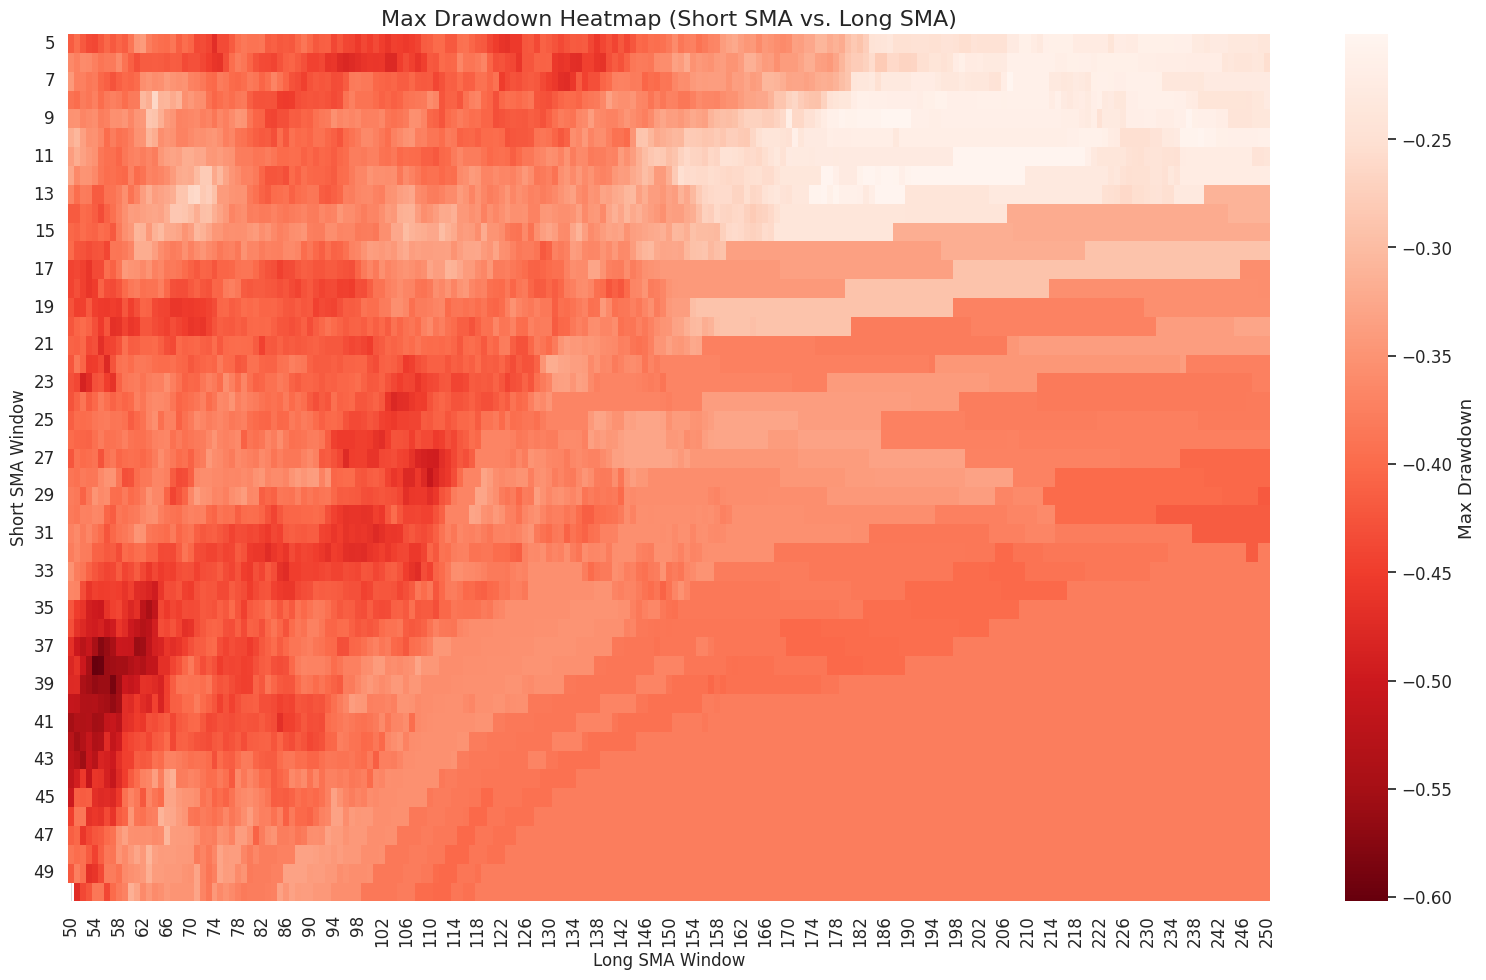

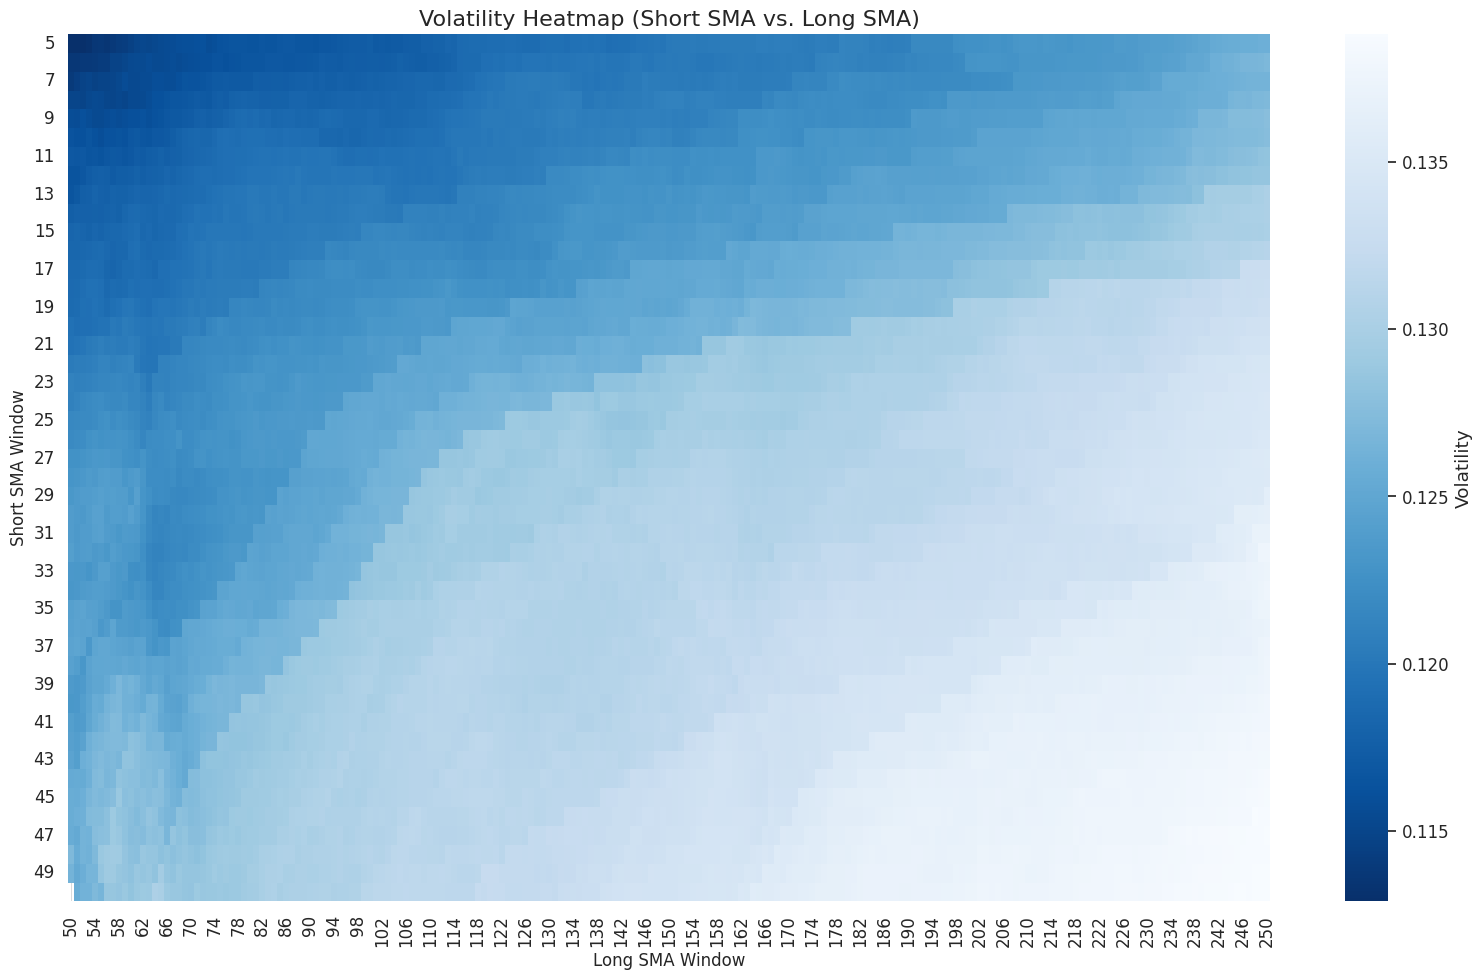

Heatmaps for Max Drawdown and Volatility generated and displayed.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a style for the plots
sns.set_style("whitegrid")

# Plotting Max Drawdown Heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(max_drawdown_heatmap_data, cmap='Reds_r', annot=False, fmt=".2f", cbar_kws={'label': 'Max Drawdown'})
plt.title('Max Drawdown Heatmap (Short SMA vs. Long SMA)', fontsize=16)
plt.xlabel('Long SMA Window', fontsize=12)
plt.ylabel('Short SMA Window', fontsize=12)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Plotting Volatility Heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(volatility_heatmap_data, cmap='Blues_r', annot=False, fmt=".2f", cbar_kws={'label': 'Volatility'})
plt.title('Volatility Heatmap (Short SMA vs. Long SMA)', fontsize=16)
plt.xlabel('Long SMA Window', fontsize=12)
plt.ylabel('Short SMA Window', fontsize=12)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("Heatmaps for Max Drawdown and Volatility generated and displayed.")

## Summary of Max Drawdown and Volatility Heatmap Insights

The heatmaps provide a visual representation of how different combinations of short and long Simple Moving Averages (SMAs) impact the maximum drawdown and volatility of the Golden Cross strategy.

### Max Drawdown Heatmap (Reds_r cmap):
- **Distribution**: The Max Drawdown heatmap (using a reversed 'Reds' colormap, so darker reds indicate lower absolute drawdown, i.e., closer to zero) shows that the least severe drawdowns (lighter colors, closer to 0) are concentrated in specific areas.
- **Low Drawdown Regions**: We observe regions of less severe drawdowns for short SMA values generally between 5-15 and long SMA values from approximately 150-250. This indicates that strategies with shorter short SMAs and longer long SMAs tend to be more effective at mitigating large losses. The heatmap visually supports the numerically identified optimal combinations around short SMA 9-12 and long SMA 186-210 for minimizing drawdown.
- **Stability**: Similar to the Sharpe and Sortino heatmaps, the areas of lower drawdown are not isolated points but broader regions, suggesting robustness to minor parameter adjustments.

### Volatility Heatmap (Blues_r cmap):
- **Distribution**: The Volatility heatmap (using a reversed 'Blues' colormap, so darker blues indicate lower volatility) highlights areas where the strategy experiences lower overall price fluctuations.
- **Low Volatility Regions**: Lower volatility (lighter colors) is predominantly found with very short short SMAs (around 5-7) and relatively shorter long SMAs (around 50-70). This suggests that more agile strategies with shorter lookback periods for both SMAs can help in smoothing out portfolio returns.
- **Contrast with Drawdown**: It's important to note a visible distinction here: the parameters yielding minimum volatility are different from those yielding minimum drawdown. Strategies designed for minimal volatility tend to be more reactive (shorter long SMAs), whereas those minimizing drawdowns might employ slightly longer long SMAs for trend confirmation.

### Overall Insights:
Both heatmaps offer valuable visual insights into the risk characteristics of the Golden Cross strategy across various parameter combinations. They confirm that optimizing for risk metrics often leads to different parameter sets than optimizing for return-adjusted metrics (like Sharpe/Sortino) or even different risk metrics themselves (max drawdown vs. volatility). The existence of broad 'sweet spots' rather than sharp peaks again indicates a degree of robustness, implying that the strategy's risk profile isn't overly sensitive to exact SMA lengths. The visual evidence supports the earlier quantitative findings, reinforcing the understanding of which SMA combinations best manage specific types of risk.

## Final Task

### Subtask:
Provide a summary of the top 10 optimal combinations for minimum maximum drawdown (closest to 0) and minimum volatility, and the overall insights from the analysis. Emphasize that the optimization aims to find combinations that minimize these risk metrics.


## Summary:

### Q&A
The top 10 short and long SMA combinations yielding the minimum maximum drawdown (closest to 0) and minimum volatility are as follows:

*   **Minimum Maximum Drawdown:**
    *   The `max_drawdown` values for these top 10 combinations ranged from approximately -0.201 to -0.203.
    *   The `short_sma` values were typically between 7 and 12, while `long_sma` values ranged from 186 to 210.
    *   Example combination: `short_sma` 9, `long_sma` 190, with a `max_drawdown` of -0.201379 and `volatility` of 0.122418.

*   **Minimum Volatility:**
    *   The `volatility` values for these top 10 combinations ranged from approximately 0.112 to 0.113.
    *   These combinations generally featured shorter `short_sma` values (around 5-6) and shorter-to-medium `long_sma` values (around 50-56).
    *   Example combination: `short_sma` 5, `long_sma` 50, with a `max_drawdown` of -0.416340 and `volatility` of 0.112892.

### Data Analysis Key Findings
*   The optimization identified specific parameter ranges for minimizing risk: short SMA values around 7-12 and long SMA values from 186-210 are effective in minimizing maximum drawdown, with values around -0.201 to -0.203.
*   For minimum volatility, optimal combinations typically involve shorter short SMAs (around 5-6) and shorter long SMAs (around 50-56), achieving volatility values of approximately 0.112 to 0.113.
*   Heatmaps visually confirmed that regions of lower maximum drawdown (closer to 0) are found with short SMA values between 5-15 and long SMA values from 150-250.
*   Lower volatility is predominantly observed with very short short SMAs (around 5-7) and relatively shorter long SMAs (around 50-70).

### Insights or Next Steps
*   The optimal SMA parameters for minimizing maximum drawdown are distinct from those that minimize volatility, indicating a trade-off between avoiding large losses and smoothing out daily price fluctuations.
*   The presence of broad "sweet spots" rather than sharp peaks in the heatmaps suggests that the strategy's risk profile exhibits a degree of robustness, meaning minor adjustments to SMA lengths will not drastically alter the risk metrics.


# Final Summary
**Final Analysis Summary of the Golden Cross Strategy on SPY (1993-2025)**

This analysis thoroughly investigated the Golden Cross trading strategy applied to the S&P 500 (SPY) data from 1993 to 2025, using a grid search optimization to identify optimal Simple Moving Average (SMA) combinations based on various performance and risk metrics.

---

### 1. Overview of Strategy and Metrics

The Golden Cross strategy involves taking a long position when a short-term SMA crosses above a long-term SMA, and moving to cash (flat) when the short-term SMA crosses below the long-term SMA. The optimization focused on a range of short SMAs (5-50 days) and long SMAs (50-250 days).

The key metrics used for optimization and evaluation were:

*   **Sharpe Ratio**: Measures risk-adjusted return, penalizing volatility.
*   **Sortino Ratio**: Similar to Sharpe, but only penalizes downside volatility.
*   **Maximum Drawdown**: Represents the largest peak-to-trough decline in a portfolio's value.
*   **Volatility**: Measures the dispersion of returns.

---

### 2. Key Findings for Each Metric

A total of 9,245 SMA combinations were evaluated, leading to distinct optimal parameter sets for different objectives:

*   **Sharpe Ratio & Sortino Ratio (Performance Focus)**:
    *   **Optimal Combination**: Short SMA 12, Long SMA 200.
    *   **Values**: Sharpe Ratio = 0.8351, Sortino Ratio = 0.9205.
    *   **Annualized Return**: 10.33%.
    *   **Insights from Heatmaps**: The heatmaps for both Sharpe and Sortino ratios showed a broad region of high performance concentrated around short SMAs of 10-20 and long SMAs of 180-220. This "flat" surface indicates that the strategy is robust and not overly sensitive to minor deviations from the exact optimal parameters. The alignment between Sharpe and Sortino rankings suggests that risk reduction is achieved through authentic volatility dampening, especially on the downside.

*   **Maximum Drawdown (Risk Mitigation Focus)**:
    *   **Optimal Combinations (Top 10)**: Short SMAs typically between 7-12 and Long SMAs between 186-210.
    *   **Values (Minimum Max Drawdown)**: Ranged from approximately -0.201 to -0.203.
    *   **Example**: Short SMA 9, Long SMA 190 yielded a Max Drawdown of -0.201379.
    *   **Insights from Heatmap**: The Max Drawdown heatmap revealed that the least severe drawdowns (closer to zero) are found for short SMAs between 5-15 and long SMAs from 150-250. This indicates that strategies employing shorter short SMAs and longer long SMAs are more effective in mitigating large losses.

*   **Volatility (Stability Focus)**:
    *   **Optimal Combinations (Top 10)**: Short SMAs around 5-6 and Long SMAs around 50-56.
    *   **Values (Minimum Volatility)**: Ranged from approximately 0.112 to 0.113.
    *   **Example**: Short SMA 5, Long SMA 50 yielded a Volatility of 0.112892.
    *   **Insights from Heatmap**: The Volatility heatmap showed lower volatility concentrated with very short short SMAs (5-7) and relatively shorter long SMAs (50-70). This suggests that more agile strategies with shorter lookback periods can help smooth out returns.

---

### 3. Predictive Value and Overfitting Concerns

The core of this exercise involved in-sample optimization, which by definition can lead to overfitting. While the strategy identified optimal parameters for historical data, their predictive value for future out-of-sample performance is limited:

*   **Sharpe/Sortino Ratios**: These ratios are highly susceptible to overfitting, especially when optimized across a large parameter space. A high historical Sharpe ratio does not guarantee future outperformance. The goal here was to demonstrate the optimization process and identify the "best" historical parameters.
*   **Maximum Drawdown and Volatility**: While still subject to in-sample bias, these risk metrics might offer a slightly more stable indication of how the strategy has historically managed risk. However, there's no guarantee that future market conditions will replicate past patterns, making future risk control equally uncertain.

The analysis specifically noted the "flat Sharpe surface" and "broad sweet spots" in the heatmaps as indicators of robustness, suggesting that the strategy's effectiveness isn't extremely fragile to minor parameter changes. This somewhat mitigates, but does not eliminate, the overfitting concern.

---

### 4. Trade-offs and Robustness

A significant finding was the clear trade-off between optimizing for performance (Sharpe/Sortino) versus optimizing for different aspects of risk (Max Drawdown vs. Volatility).

*   **Performance vs. Risk**: The optimal (12, 200) SMA combination for Sharpe/Sortino ratios offered superior risk-adjusted returns compared to a simple buy-and-hold strategy (Sharpe: 0.8351 vs. 0.6357), but with a slightly lower annualized return (10.33% vs. 11.87%). This highlights the strategy's ability to improve risk-adjusted metrics by systematically avoiding downturns, rather than just maximizing raw returns.
*   **Different Risk Objectives**: The parameters for minimizing maximum drawdown (longer short and long SMAs) were distinct from those minimizing volatility (shorter short and long SMAs). This implies that a choice must be made based on the investor's primary risk concern – avoiding large single losses (drawdown) or smoothing out general price fluctuations (volatility).
*   **Robustness**: The heatmaps visually confirmed that high-performing or low-risk regions were not isolated points but "broad sweet spots." This indicates a degree of robustness, suggesting that the strategy's performance isn't overly sensitive to finding one exact, perfect combination of SMAs. This reduces the practical risk associated with parameter selection.

---

### 5. Recommendations for Next Steps

Given the in-sample nature of this optimization, the following steps are crucial for developing a truly robust and actionable trading strategy:

1.  **Out-of-Sample Testing (Backtesting)**: The most critical next step is to rigorously test the identified optimal parameters on data periods not used in the optimization. This will provide a more realistic assessment of the strategy's true predictive value and reveal how well it generalizes to unseen market conditions.
2.  **Walk-Forward Optimization**: Instead of a single in-sample optimization, a walk-forward analysis can be performed, where parameters are optimized over a rolling window of historical data and then applied to the subsequent out-of-sample period. This simulates real-world trading more closely.
3.  **Multi-Objective Optimization**: Explore methods that consider multiple objectives simultaneously (e.g., maximizing Sharpe while minimizing drawdown) to find a more balanced set of parameters, potentially using techniques like Pareto fronts.
4.  **Transaction Costs and Slippage**: Incorporate realistic transaction costs (commissions, bid-ask spread) and potential slippage into the return calculations. These factors can significantly erode profitability, especially for strategies with higher trading frequency.
5.  **Dynamic Parameter Adjustment**: Investigate adaptive approaches where SMA lengths are dynamically adjusted based on prevailing market regimes (e.g., trending vs. sideways markets).
6.  **Alternative Assets and Market Conditions**: Test the strategy on different asset classes (e.g., bonds, commodities, other equities) and across various economic cycles to assess its universality.
7.  **Fundamental and Macroeconomic Integration**: Consider how the Golden Cross signal could be combined with fundamental analysis or macroeconomic indicators for enhanced decision-making.

In conclusion, this analysis has successfully demonstrated the process of optimizing a Golden Cross strategy using historical data for various metrics and has highlighted important trade-offs and robustness considerations. However, it strongly underscores the need for thorough out-of-sample validation before any real-world application.